# **MILESTONE 2**

## **INTRODUCTION**

Dataset yang digunakan pada penelitian ini dapat diunduh di [link](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset).

Pada Notebook ini akan dilakukan proses pengategorian terhadap kejadian stroke pada pasien. Mengacu pada *World Health Organization* (WHO) faktor risiko akan kejadian stroke pada seseorang dapat diamati berdasarkan kondisi klinis seperti: Diabetes, Hipertensi, Kolesterol tinggi, maupun faktor genetik, serta demografis; seperti umur. Selain itu kebiasaan merokok dan konsumsi alkohol juga berperan sebagai faktor risiko. Pada dataset ini, terdapat data tambahan diluar yang sudah disebutkan sebelumnya; seperti status menikah, tipe pekerjaan, serta tempat tinggal, dan akan diamanti bagaimana pengaruhnya terhadap kejadian stroke. Tentunya, dalam proses pemodelan hanya akan menyertakan features yang relevan terhadap label target.

Proses pemodelan akan dilakukan menggunakan 4 algoritma, yaitu Linear Regression serta Gussian Naive Bayes, Random Forest Classifier dan XGBoost lalu dipilih model terbaik berdasarkan metrics yang berkaitan dengan study kasus ini. Adapun features serta target yang berada pada dataset ini adalah:

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient


**Acknowledgements**

Sumber asli dari data ini bersifat ***confidential*** dan hanya dapat digunakan dalam ***educational purposes*** saja.

## **IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from feature_engine.outliers import Winsorizer
from imblearn.over_sampling import SMOTENC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle

import warnings
warnings.filterwarnings("ignore")

## **DATA LOADING AND OVERVIEW**

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# check total entries and columns
df.shape

(5110, 12)

In [5]:
# check duplicated data
df[df.duplicated()].shape

(0, 12)

Tidak terdapat data duplikat.

In [6]:
# checking missing values
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
df[df.stroke==1]['bmi'].isnull().sum()

40

Terdapat 201 entry missing value pada kolom BMI. Semenjak feature ini memiliki kausalitas yang tinggi terhadap target, maka diputuskan untuk menghilangkan (complete case analysis) entry missing value.

In [8]:
df.dropna(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   object 
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   object 
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   object 
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 498.6+ KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4909.0,37064.313506,20995.098457,77.00,18605.00,37608.00,55220.00,72940.00
age,4909.0,42.865374,22.555115,0.08,25.00,44.00,60.00,82.00
hypertension,4909.0,0.091872,0.288875,0.00,0.00,0.00,0.00,1.00
heart_disease,4909.0,0.049501,0.216934,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,4909.0,105.305150,44.424341,55.12,77.07,91.68,113.57,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.50,28.10,33.10,97.60
stroke,4909.0,0.042575,0.201917,0.00,0.00,0.00,0.00,1.00


In [11]:
cat = [i for i in df.columns if i not in df.describe().columns]

for i in cat:
    print(i,'\n')
    print(df[i].value_counts())
    print('-'*50)

gender 

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64
--------------------------------------------------
ever_married 

Yes    3204
No     1705
Name: ever_married, dtype: int64
--------------------------------------------------
work_type 

Private          2811
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64
--------------------------------------------------
Residence_type 

Urban    2490
Rural    2419
Name: Residence_type, dtype: int64
--------------------------------------------------
smoking_status 

never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64
--------------------------------------------------


In [12]:
# proporsi label target 1 terhadap data total
df[df.stroke==1].shape[0] / df.shape[0] * 100

4.257486249745366

Based on basic overview, we can conclude:
- No duplicated entry on dataset
- There are 201 missing values on BMI, we decide to drop these entries because in this case BMI has high causality towards target label
- `Age` has minimum value of 0.08, need further exploration
- `avg_glucose_level` and `bmi` have max value that far from its third quartil.
- `gender` has 1 entry labeled as `Other`.
- `work_type` has label `children`. This label can be figured from `age` feature, so we will transform it to `Never worked`.
- `smoking status` has label `unknown`.
- This dataset is highly imbalance, with minority proportion 4.87% from total dataset.

## **DATA CLEANING**

**Perlakuan terhadap label `Other` pada `Gender`**

In [13]:
df[df.gender=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Since label `Other` from `Gender` only have 1 entry, we can remove it.

In [14]:
# Melakukan drop dan memastikan keberadaan data sudah tidak ada
df = df[df.gender!='Other']

df[df.gender=='Other'].shape

(0, 12)

**Perlakuan terhadap label `children` pada feature `work_type`**

In [15]:
df[df.work_type=='children']['age'].max()

16.0

label `children` pada feature `work_type` memiliki umur maksimal 16 tahun.

Pertanyaan lainnya, apakah usia dibawah sama dengan usia 16 tahun memiliki label `work_type` selain `children`?

In [16]:
df[df.age<=16]['work_type'].value_counts()

children         671
Private           83
Never_worked      12
Self-employed      9
Govt_job           3
Name: work_type, dtype: int64

Terdapat beberapa hal menarik berkaitan temuan diatas, tetapi tidak akan dibahas terlebih dahulu semenjak data belum dipisahkan antara train dan test.

Untuk perlakuan sejauh Data Cleaning, label `children` pada feature `work_type` akan diubah dan diasumsikan sebagai `Never_worked`.

In [17]:
df['work_type'].replace({'children': 'Never_worked'}, inplace=True)

In [18]:
df.work_type.value_counts()

Private          2810
Self-employed     775
Never_worked      693
Govt_job          630
Name: work_type, dtype: int64

**Split dataset**

Dataset akan dipisahkan menjadi data:
- train digunakan dalam proses eksplorasi dan acuan dalam pembuatan model.
- test digunakan dalam mengevaluasi model

In [19]:
X = df.drop('stroke', axis=1).copy()
y = df.stroke.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [20]:
def print_shape(features, target, tipe):
    print('Jumlah entry data pada X_%s:'%tipe, features.shape)
    print('Jumlah entry data pada y_%s:'%tipe, target.shape)
    print('-'*50)

print_shape(X_train, y_train, 'train')
print_shape(X_test, y_test, 'test')


Jumlah entry data pada X_train: (3926, 11)
Jumlah entry data pada y_train: (3926,)
--------------------------------------------------
Jumlah entry data pada X_test: (982, 11)
Jumlah entry data pada y_test: (982,)
--------------------------------------------------


## **EDA MODELING**

In [21]:
X_train_eda = X_train.copy()

In [22]:
df_exp = pd.concat([y_train, X_train], axis=1)
df_exp.drop('id', axis=1, inplace=True)
df_exp.shape

(3926, 11)

**early feature selection using phik**

interval columns not set, guessing: ['stroke', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


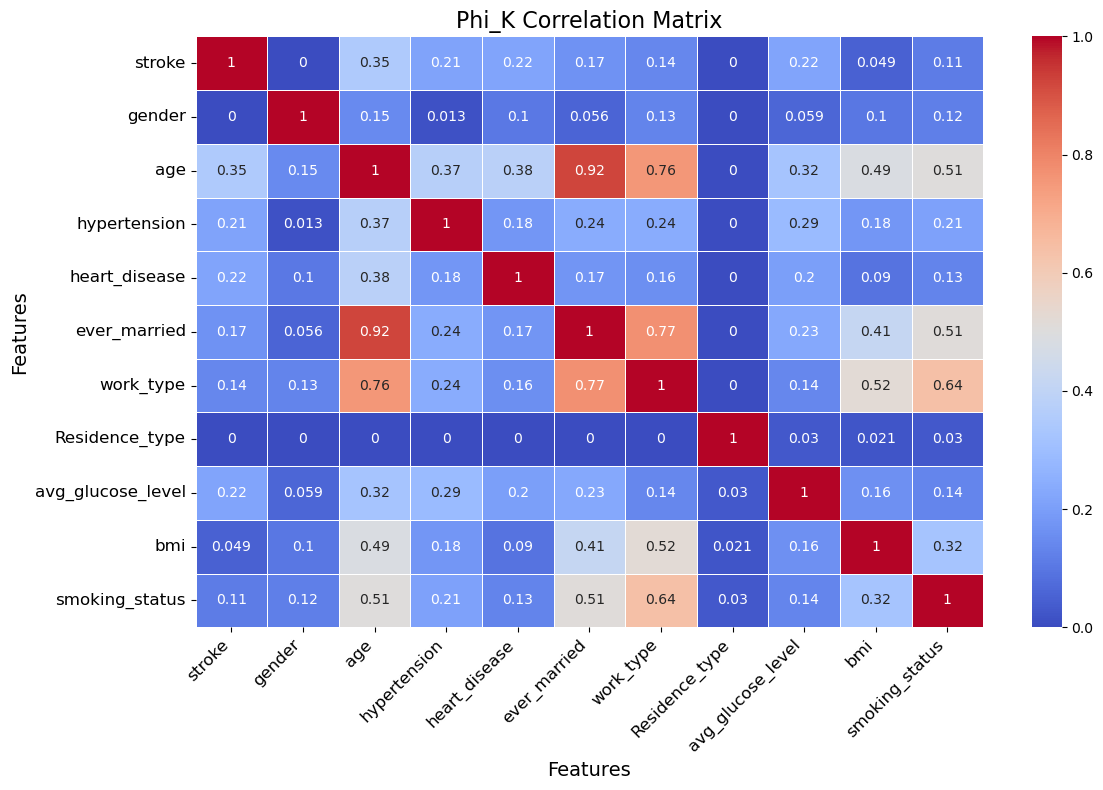

In [23]:
# get the phi_k correlation matrix between all variables
phik_matrix = df_exp.phik_matrix()

# plot the correlation matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

# set the title and axis labels
plt.title("Phi_K Correlation Matrix", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Features", fontsize=14)

# rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# display the plot
plt.tight_layout()
plt.show()

Based on phik feature selection, can be concluded:
- `age`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `avg_glucose_level`, and `smoking_status` has more than 0.1 score realtionship towards targer.
- `gender` and `bmi` have low score, but theoritically it have high causality towards target. so we will keep those 2 feature for now.

In [24]:
num = ['age', 'avg_glucose_level', 'bmi']
cat = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'smoking_status']

**categorical feature**

Proses encoding selanjutnya akan dilakuakan terhadap feature:
- Ordinal encoder terhadap: `gender`, `hypertension`, `heart_disease`, `ever_married`, `smoking_status`
- One hot encoding terhadap: `work_type`

Perihal Label `Unknown` pada feature `smoking_status` memiliki artian tidak diketahuinya status merokok pada pasien, yang mana bisa berarti salah satu dari ketiga data lainnya.

Pada Notebook ini diputuskan tidak dilakukan pengalihan label terhadap `Unknown`, tetapi nilai label pada feature ini akan ditransformasi menjadi nilai ordinal dengan tingkatan sesuai faktor resiko, yaitu:
- 0: never smoked
- 1: Unknown
- 2: formerly smoked
- 3: smokes

In [25]:
for_ord = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'smoking_status']
for_ohe = ['work_type']

In [26]:
# ordinal encoder
gender = ['Female', 'Male']
hypertension = [0, 1]
heart_d = [0,1]
ever_married = ['No', 'Yes']
smoking = ['never smoked', 'Unknown', 'formerly smoked', 'smokes']

ord = OrdinalEncoder(categories=[gender, hypertension, heart_d, ever_married, smoking])
X_train_ord = pd.DataFrame(ord.fit_transform(X_train_eda[for_ord]))
X_train_ord.columns = for_ord
X_train_ord.head(2)

,gender,hypertension,heart_disease,ever_married,smoking_status
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,3.0


In [27]:
#one hot encoder
ohe = OneHotEncoder(sparse=False)
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_eda[for_ohe]))
X_train_ohe.columns = ohe.get_feature_names(['worktype'])
X_train_ohe.head(2)

,worktype_Govt_job,worktype_Never_worked,worktype_Private,worktype_Self-employed
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0


**Feature selection using correlation matrix and feature importance**

Pada section ini akan dilakukan feature selection lebih lanjut melalui sudut pandang correlation dan feature importance

In [28]:
# concat encoded categorical into numerical and target
df_exp = pd.concat([df_exp[num].reset_index(drop=True),
           X_train_ohe, X_train_ord,
           df_exp['stroke'].reset_index(drop=True)], axis=1)

df_exp.head(3)


,age,avg_glucose_level,bmi,worktype_Govt_job,worktype_Never_worked,worktype_Private,worktype_Self-employed,gender,hypertension,heart_disease,ever_married,smoking_status,stroke
0,24.0,73.49,23.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,26.0,89.28,21.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0
2,22.0,73.50,41.3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0


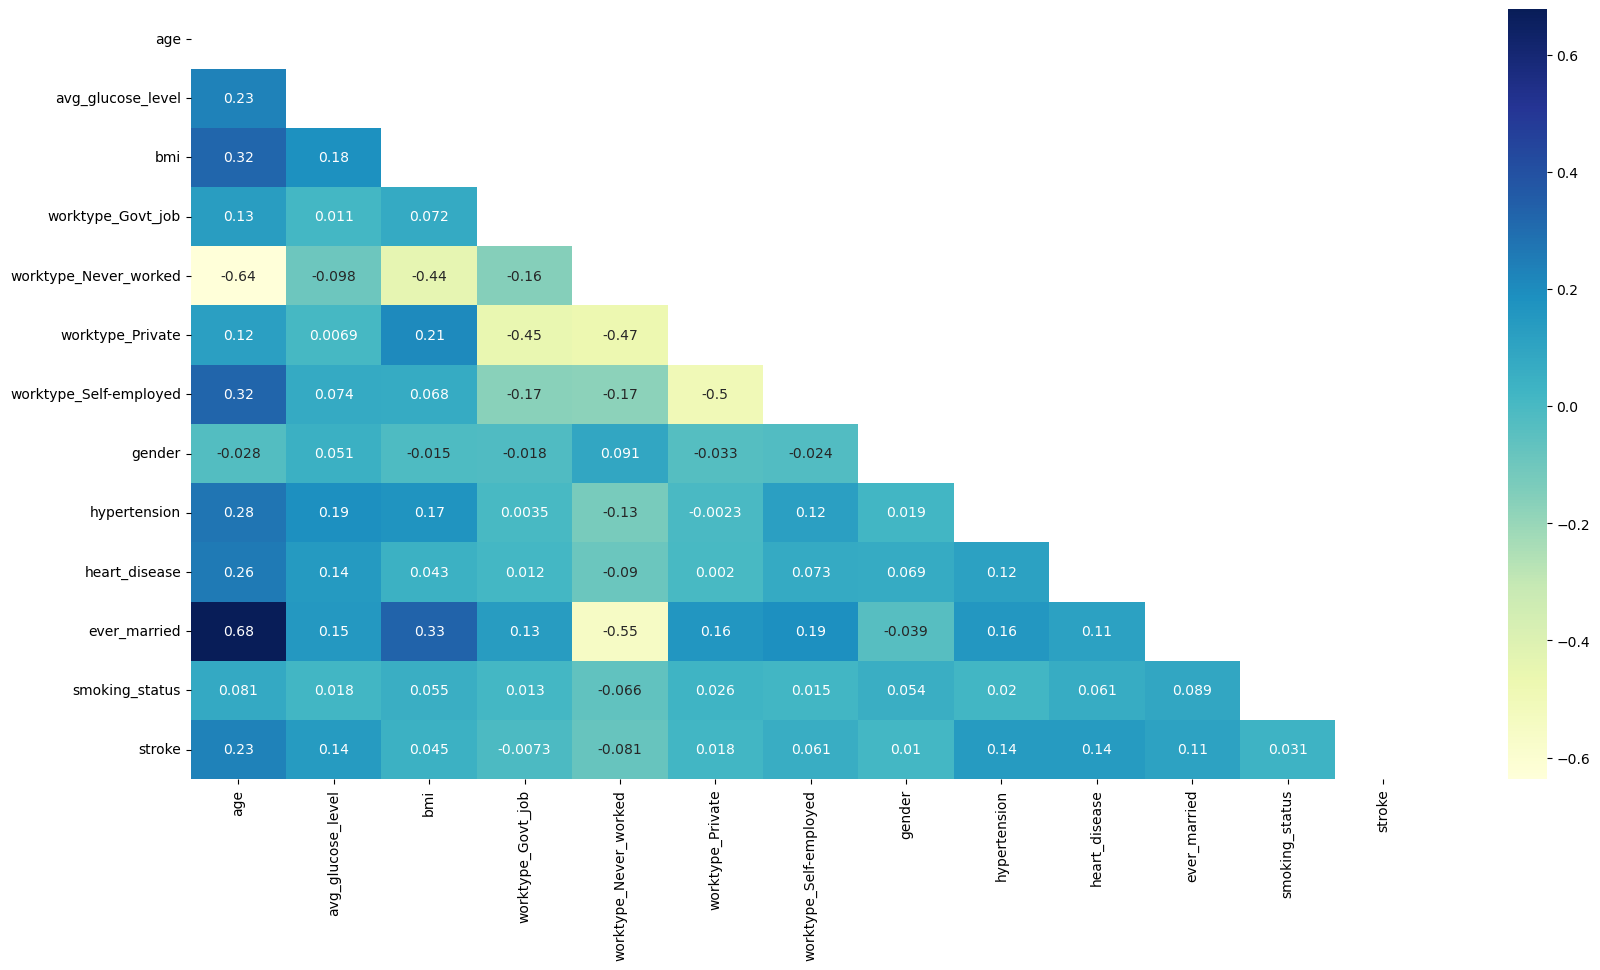

In [29]:
# Melihat korelasi pada data

fig,ax = plt.subplots(figsize=[20,10])
corr = df_exp.corr()

mask = np.triu(np.ones_like(corr))

ax = sns.heatmap(corr, cmap="YlGnBu", mask=mask,annot=True)
plt.show()

<AxesSubplot:>

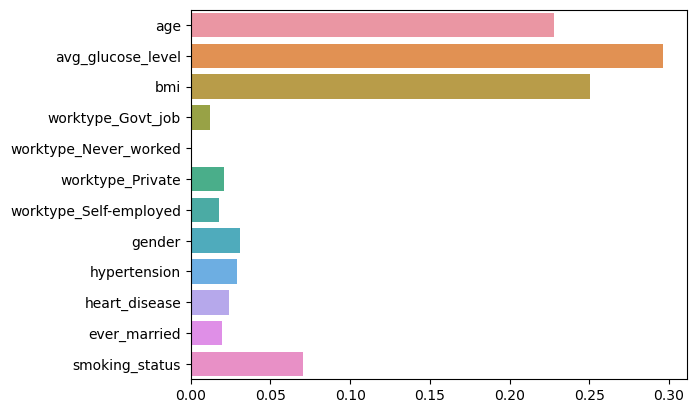

In [30]:
rfc = RandomForestClassifier()
rfc.fit(df_exp.drop('stroke', axis=1), df_exp['stroke'])

sns.barplot(x=rfc.feature_importances_, y=df_exp.drop('stroke', axis=1).columns)

Bila disimpulkan, feature yang memiliki korelasi "relatif" tinggi terhadap target `stroke` merupakan data klinis yang menggambarkan kondisi kesehatan pasien.

Berdasarkan hasil tersebut akan dipilih features yang masih relevan untuk dianalisis lebih lanjut, yaitu:
`age`, `avg_glucose_level`, `bmi`, `hypertension`, `heart_disease`, `smoking_status`

In [31]:
num = ['age', 'avg_glucose_level']
cat = ['hypertension', 'heart_disease', 'smoking_status']

**numerical feature**

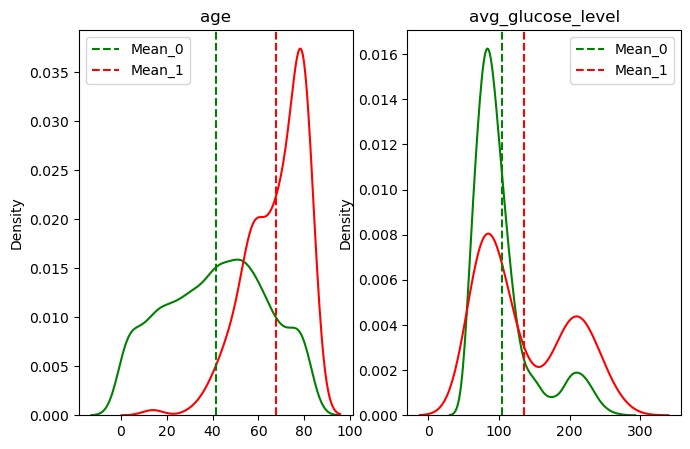

In [32]:
plt.figure(figsize=[12,5])

for i, column in enumerate(df_exp[num].columns):
    i += 1
    ax = plt.subplot(1, 3, i)

    sns.kdeplot(ax=ax,data=df_exp[df_exp.stroke==0][num], x=column, color='g')
    sns.kdeplot(ax=ax,data=df_exp[df_exp.stroke==1][num], x=column, color='r')

    ax.axvline(df_exp[df_exp.stroke==0][column].mean(), color='g', linestyle='--', label="Mean_0")
    ax.axvline(df_exp[df_exp.stroke==1][column].mean(), color='r', linestyle='--', label="Mean_1")
    ax.legend()
    
    ax.set(xlabel='')

    plt.title(column)

Pada visualisasi diatas didapatkan:
- Penderita stroke memiliki sebaran umur diatas non-penderita stroke, dengan nilai rata-rata diatas 60 tahun.
- Ditinjau melalui rata-rata gula darah, bentuk sebaran diantara kedua label target hampir tidak ditemukan perbedaan kecuali pada label non-stroke secara proporsi persebaran data pada nilai sebelum 150 lebih banyak diabndingkan label stroke, hal ini dapat terlihat dengan nilai rata-rata yang lebih rendah.
- Ditinjau berdasarkan indeks masa tubuh, sebaran pada label stroke sedikit lebih mengerucut dibandingkan sebaran pada label non-stroke. Terlihat dengan nilai density yang lebih besar.

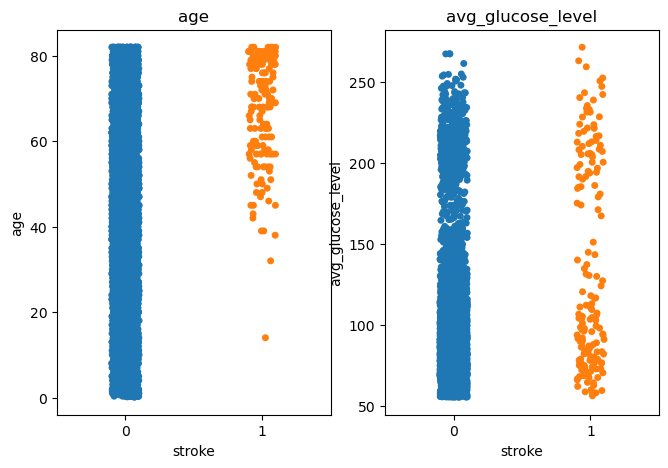

In [33]:
plt.figure(figsize=[12,5])

for i, column in enumerate(df_exp[num].columns):
    i += 1
    plt.subplot(1, 3, i)

    sns.stripplot(data=df_exp, y=column, x='stroke')

    plt.title(column)

Berdasarkan visualisasi sebaran data menggunakan stripplot, didapatkan:
- Berdasarkan umur, penderita stroke memiliki minimal umur sebesar 32 tahun. (Rujukan 1)
- Tidak terdapat perbedaan pasti antara kelompok stroke berdasarkan bmi, maka feature bmi tidak diikutkan dalam pemodelan

In [34]:
# Rujukan 1 - Umur minimal penderita stroke
df_exp[df_exp.stroke==1]['age'].min()

14.0

In [35]:
# feature scaling
for i in num:
    print(f'{i}: {np.round(df_exp[i].skew(), 2)}')

age: -0.1
avg_glucose_level: 1.61


Karena mayoritas memiliki sebaran tidak normal, maka scaling akan menggunakan standard scaler.

In [36]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(df_exp[num])
X_train_num

array([[-0.83408792, -0.71754466],
       [-0.74512688, -0.36186277],
       [-0.92304896, -0.71731941],
       ...,
       [ 1.25649651,  0.00846088],
       [-0.1223996 , -0.0507819 ],
       [-1.88738663, -0.712589  ]])

**Handling Imbalance dataset**

Akan dilakukan handling imbalance data menggunakan SMOTENC dengan melakukan oversampling terhdapa minority class

In [37]:
X_eda = df_exp.drop('stroke', axis=1)
y_eda = df_exp['stroke']
X_eda.iloc[:, list(range(3,12))]

,worktype_Govt_job,worktype_Never_worked,worktype_Private,worktype_Self-employed,gender,hypertension,heart_disease,ever_married,smoking_status
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...
3921,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0
3922,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3923,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
3924,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [38]:
cat_index = list(range(3,12))

smotenc = SMOTENC(cat_index, sampling_strategy=.9)
X_eda, y_eda = smotenc.fit_resample(X_eda, y_eda)

y_eda.value_counts()


0    3759
1    3383
Name: stroke, dtype: int64

## **DATA PREPROCESSING**

Tahapan Preprocessing yang telah dilakukan sejauh ini adalah:
- Feature terpilih berdasarkan EDA Modeling: `age`, `avg_glucose_level`, `hypertension`, `heart_disease`, `smoking_status`
- Terhadap Data Train:
    - categorical: 
        - ordinal encoder terhadap: `hypertension`, `heart_disease`, `smoking_status`
    - numerikal:
        - scaling pada seluruh feature numerik menggunakan `standard scaler`
    - dilakukan balancing menggunakan `SMOTENC`

In [39]:
num_pipe = Pipeline([
    ('scaling', StandardScaler())
])

pd.DataFrame(num_pipe.fit_transform(X_train[num])).head(5)

,0,1
0,-0.834088,-0.717545
1,-0.745127,-0.361863
2,-0.923049,-0.717319
3,0.322406,-0.471789
4,0.989613,-0.377856


In [40]:
hypertension = [0, 1]
heart_d = [0,1]
smoking = ['never smoked', 'Unknown', 'formerly smoked', 'smokes']


cat_pipe = Pipeline([
    ('ord_enc', OrdinalEncoder(categories=[hypertension, heart_d, smoking]))
])

pd.DataFrame(cat_pipe.fit_transform(X_train[cat])).head()

,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,3.0
2,0.0,0.0,3.0
3,0.0,0.0,2.0
4,0.0,0.0,3.0


In [41]:
prep = ColumnTransformer([
    ('num', num_pipe, num),
    ('cat', cat_pipe, cat)
])

full_prep = imbpipe([
    ('prep', prep),
    ('balancing', SMOTENC([2,3,4], sampling_strategy=.95))
])

train_resampled, y_resampled = full_prep.fit_resample(X_train, y_train)

## **MODEL BUILDING, TRAINING AND EVALUATION**

Pada tahapan ini akan dilakukan proses pengujian model menggunakan dua algoritma:
1. Logistic Regression
2. Gaussian Naive Bayes
3. Bagging - Random Forest
4. Bosting - XGBoost

### **Defining Function**

Mempersiapkan fungsi yang akan digunakan.

In [42]:
def f_pipe_grid(model, param):
    full_prep = imbpipe([
                        ('prep', prep),
                        ('balancing', SMOTENC([2,3,4], sampling_strategy=.85)),
                        ('pemodelan', model)
                        ])

    skf = StratifiedKFold(n_splits=5)
    grid = GridSearchCV(full_prep, param_grid=param, scoring='recall_macro', cv=skf)
    grid.fit(X_train, y_train)
    print("Best cross-validation recall: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))
    # print(grid.best_estimator_)

    mod = grid.best_estimator_

    mod.fit(X_train, y_train)
    train_pred = mod.predict(X_train)
    test_pred = mod.predict(X_test)

    print('Train set:\n', classification_report(y_train,train_pred))
    print('\nTest set:\n', classification_report(y_test, test_pred))
    return mod

## **Logistic Regression**

In [43]:
# Melakukan Grid Search CV menggunakan pipeline
param = {'pemodelan__penalty': ['l2', 'l1', 'none'],
        'pemodelan__solver': ['newton-cg', 'lbfgs', 'sag'],
        'pemodelan__class_weight': ['balanced', 'None']
        }

logreg = f_pipe_grid(LogisticRegression(), param)

Best cross-validation recall: 0.76
Best parameters: {'pemodelan__class_weight': 'balanced', 'pemodelan__penalty': 'l2', 'pemodelan__solver': 'sag'}
Train set:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85      3759
           1       0.12      0.81      0.21       167

    accuracy                           0.74      3926
   macro avg       0.56      0.78      0.53      3926
weighted avg       0.95      0.74      0.82      3926


Test set:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83       940
           1       0.11      0.76      0.19        42

    accuracy                           0.72       982
   macro avg       0.55      0.74      0.51       982
weighted avg       0.95      0.72      0.80       982



## **Naive Bayes**

In [44]:
# Melakukan Grid Search CV menggunakan pipeline
param = {'pemodelan__var_smoothing': [0.01, 0.015, 0.02]
        }

gnb = f_pipe_grid(GaussianNB(), param)

Best cross-validation recall: 0.75
Best parameters: {'pemodelan__var_smoothing': 0.02}
Train set:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      3759
           1       0.14      0.62      0.23       167

    accuracy                           0.82      3926
   macro avg       0.56      0.72      0.57      3926
weighted avg       0.94      0.82      0.87      3926


Test set:
               precision    recall  f1-score   support

           0       0.98      0.81      0.88       940
           1       0.12      0.62      0.21        42

    accuracy                           0.80       982
   macro avg       0.55      0.71      0.55       982
weighted avg       0.94      0.80      0.85       982



## **Random Forest**

In [45]:
# Melakukan Grid Search CV menggunakan pipeline
param = {'pemodelan__criterion': ['gini', 'entropy'],
        'pemodelan__max_depth': [3, 7, 10],
        'pemodelan__min_samples_split': [ 2, 7, 10],
        'pemodelan__max_features': [None, 2, 5]
        }

rfc = f_pipe_grid(RandomForestClassifier(), param)

Best cross-validation recall: 0.78
Best parameters: {'pemodelan__criterion': 'entropy', 'pemodelan__max_depth': 3, 'pemodelan__max_features': 2, 'pemodelan__min_samples_split': 10}
Train set:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85      3759
           1       0.13      0.84      0.23       167

    accuracy                           0.76      3926
   macro avg       0.56      0.79      0.54      3926
weighted avg       0.95      0.76      0.83      3926


Test set:
               precision    recall  f1-score   support

           0       0.98      0.73      0.84       940
           1       0.11      0.74      0.19        42

    accuracy                           0.73       982
   macro avg       0.55      0.73      0.51       982
weighted avg       0.95      0.73      0.81       982



## **XGBoost**

In [46]:
# Melakukan Grid Search CV menggunakan pipeline
param = {'pemodelan__learning_rate': [0.01, 0.1],
        'pemodelan__max_depth': [2, 4, 5],
        'pemodelan__gamma': [ 0, 0.01, 0.5],
        'pemodelan__objective': ['binary:logistic']
        }

xgbclf = f_pipe_grid(xgb.XGBClassifier(), param)

Best cross-validation recall: 0.77
Best parameters: {'pemodelan__gamma': 0.01, 'pemodelan__learning_rate': 0.01, 'pemodelan__max_depth': 2, 'pemodelan__objective': 'binary:logistic'}
Train set:
               precision    recall  f1-score   support

           0       0.99      0.71      0.82      3759
           1       0.11      0.83      0.20       167

    accuracy                           0.71      3926
   macro avg       0.55      0.77      0.51      3926
weighted avg       0.95      0.71      0.80      3926


Test set:
               precision    recall  f1-score   support

           0       0.99      0.67      0.80       940
           1       0.10      0.81      0.18        42

    accuracy                           0.68       982
   macro avg       0.54      0.74      0.49       982
weighted avg       0.95      0.68      0.77       982



Berdasarkan pengujian ke-4 model, secara keseluruhan model masih kesulitan memprediksi label stroke. meskipun skor recall di data test dapat melebihi 70% tetapi performa precision masih minim. artinya masih terlalu banyak entry data yang tidak stroke tapi diprediksi sebagai stroke.

Dari ke-4 model, performa paling baik ditunjukkan oleh XGBoost classifier dimana memiliki skor recall stroke pada test lebih baik dibandingkan logistic regression maupun naive bayes, dan tidak se-overfit Random Forest Classifier.

Maka diputuskan model XGBoost yang akan dilakukan inference/deployment.

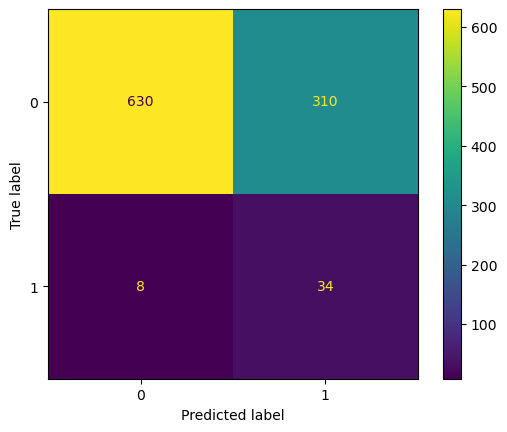

In [47]:
cm = confusion_matrix(y_test, xgbclf.predict(X_test), labels=xgbclf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=xgbclf.classes_)

disp.plot()

In [48]:
xgbclf

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('ord_enc',
                                                                   OrdinalEncoder(categories=[[0,
                                                                                               1],
                                                                                              [0,
                                                                                               1],
                                                                                              ['never '
                                                                                               'smoked',
                                                                                               'Unknown',
                                                                                               'formerly '
                                                                                               'smoked',
                                                                                               'smokes']]))]),
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'smoking_status'])])),
                ('balancing',
                 SMOTENC(ca...
                               feature_types=None, gamma=0.01, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [49]:
# save model
pickle.dump(xgbclf, open("model.pkl", "wb"))

## **MODEL INFERENCE**

Pengujian model terhadap data inference menggunakan model terpilih yaitu XGBoost classifier.

In [50]:
# load model
model = pickle.load(open("model.pkl", "rb"))

In [51]:
# input inference data
inf = pd.DataFrame(data=[[687999, 'Male', 35.0, 0, 1, 'No', 'Private', 'Urban', 142.62,
        40.4, 'formerly smoked']],
            columns=['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'])

inf

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,687999,Male,35.0,0,1,No,Private,Urban,142.62,40.4,formerly smoked


In [52]:
# Send data to pipeline
result = model.predict(inf)
result

array([0])

In [53]:
# interpretability
if result[0] == 0:
    print('Not Stroke')
else:
    print('Stroke')

Not Stroke


__________________
__________________

In [55]:
import sklearn
sklearn.__version__

'1.1.1'

In [56]:
import feature_engine
feature_engine.__version__

'1.5.2'